# GAN Model 
1. Define the discriminator and generator.
2. Define the GAN with discriminator and generator
3. Generate real samples
4. Generate fake samples
4. Train the model with real and fake images


### References
- Link 1
*https://www.kaggle.com/code/tsrtsr/gan-fer2013-disgust*
- Link 2
-*https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/*

## Import libraries

In [3]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

### Define discriminator

In [4]:
# define the standalone discriminator model
# def define_discriminator(in_shape=(32,32,3)):
def define_discriminator(in_shape=(48,48,1)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### Define Generator

In [6]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    # n_nodes = 256 * 4 * 4
    n_nodes = 256 * 6 * 6
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(Reshape((4, 4, 256)))
    model.add(Reshape((6, 6, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    # model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    model.add(Conv2D(1, (3,3), activation='tanh', padding='same'))
    return model

### Define combined GAN

In [7]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [9]:
# load and prepare cifar10 training images
def load_real_samples2():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [10]:
# load and prepare FER2013 (disgust) training images
import numpy as np
import cv2
import os

def load_real_samples(class_to_generate):
    trainX = np.empty([0, 48, 48, 1])

    # Load in the images
    for filepath in os.listdir('../datasets/FER_2013/train/' + class_to_generate):
        img = cv2.imread('../datasets/FER_2013/train/' + class_to_generate + '/{0}'.format(filepath),0)
        img = img.reshape(1, 48, 48, 1)
        trainX = (np.concatenate((trainX, img)))
    
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

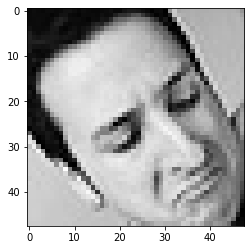

In [11]:
dataset = load_real_samples(class_to_generate) # (50000, 32, 32, 3)
dataset.shape
pyplot.imshow(255-dataset[0], cmap = 'Greys')
pyplot.show()

In [12]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [13]:
X_real, y_real = generate_real_samples(dataset, 150)

In [14]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [15]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [16]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [17]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    #filename = 'generator_model_%03d.h5' % (epoch+1)
    #g_model.save(filename)
int(dataset.shape[0])

436

In [18]:
dataset = load_real_samples('angry')
print(int(dataset.shape[0]))

3995


In [19]:
n_batch=1280
bat_per_epo = int(dataset.shape[0] / n_batch)
print(bat_per_epo)

3


In [28]:
# train the generator and discriminator
class_to_generate = 'disgust'
def train(g_model, d_model, gan_model, dataset, latent_dim, category, n_epochs=500, n_batch=1280):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        print("epoch is " + str(i))
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            print("Batch no: " + str(j))
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        #if (i+1) % 10 == 0:
            #summarize_performance(i, g_model, d_model, dataset, latent_dim)
    filename = category + '_generator_model.h5'
    g_model.save(filename)

## Perform training for the GAN
1. Perform training with each category
2. Save the model for each category separately

*Note: Since training for each category is time intensive, number of epochs were reduced to 500 and each category was separately ran without a loop*

In [51]:
fer_classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
category = "surprise"
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(category)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, category)

Working on category surprise
epoch is 0
Batch no: 0
20/20 [==============================] - 12s 614ms/step
>1, 1/2, d1=0.689, d2=0.709 g=0.692
Batch no: 1
20/20 [==============================] - 13s 632ms/step
>1, 2/2, d1=0.504, d2=0.726 g=0.690
epoch is 1
Batch no: 0
20/20 [==============================] - 13s 636ms/step
>2, 1/2, d1=0.125, d2=1.293 g=0.685
Batch no: 1
20/20 [==============================] - 11s 559ms/step
>2, 2/2, d1=0.059, d2=1.055 g=0.916
epoch is 2
Batch no: 0
20/20 [==============================] - 11s 546ms/step
>3, 1/2, d1=0.204, d2=0.613 g=0.895
Batch no: 1
20/20 [==============================] - 11s 543ms/step
>3, 2/2, d1=0.113, d2=0.657 g=0.774
epoch is 3
Batch no: 0
20/20 [==============================] - 11s 546ms/step
>4, 1/2, d1=0.049, d2=1.122 g=0.790
Batch no: 1
20/20 [==============================] - 11s 544ms/step
>4, 2/2, d1=0.044, d2=1.052 g=0.804
epoch is 4
Batch no: 0
20/20 [==============================] - 11s 544ms/step
>5, 1/2, d1=0.17

20/20 [==============================] - 12s 576ms/step
>38, 1/2, d1=0.774, d2=0.641 g=1.605
Batch no: 1
20/20 [==============================] - 11s 558ms/step
>38, 2/2, d1=0.868, d2=0.787 g=1.220
epoch is 38
Batch no: 0
20/20 [==============================] - 11s 562ms/step
>39, 1/2, d1=0.814, d2=0.751 g=1.195
Batch no: 1
20/20 [==============================] - 11s 562ms/step
>39, 2/2, d1=0.736, d2=0.566 g=1.556
epoch is 39
Batch no: 0
20/20 [==============================] - 11s 569ms/step
>40, 1/2, d1=0.715, d2=0.520 g=1.495
Batch no: 1
20/20 [==============================] - 11s 557ms/step
>40, 2/2, d1=0.639, d2=0.798 g=1.031
epoch is 40
Batch no: 0
20/20 [==============================] - 11s 557ms/step
>41, 1/2, d1=0.684, d2=0.796 g=0.957
Batch no: 1
20/20 [==============================] - 11s 554ms/step
>41, 2/2, d1=0.689, d2=0.597 g=1.136
epoch is 41
Batch no: 0
20/20 [==============================] - 12s 581ms/step
>42, 1/2, d1=0.692, d2=0.512 g=1.262
Batch no: 1
20/20 [

20/20 [==============================] - 11s 559ms/step
>75, 1/2, d1=0.613, d2=0.628 g=1.452
Batch no: 1
20/20 [==============================] - 11s 557ms/step
>75, 2/2, d1=0.579, d2=0.536 g=1.638
epoch is 75
Batch no: 0
20/20 [==============================] - 11s 558ms/step
>76, 1/2, d1=0.539, d2=0.538 g=1.608
Batch no: 1
20/20 [==============================] - 11s 556ms/step
>76, 2/2, d1=0.514, d2=0.711 g=1.343
epoch is 76
Batch no: 0
20/20 [==============================] - 13s 634ms/step
>77, 1/2, d1=0.572, d2=0.799 g=1.292
Batch no: 1
20/20 [==============================] - 13s 640ms/step
>77, 2/2, d1=0.635, d2=0.778 g=1.278
epoch is 77
Batch no: 0
20/20 [==============================] - 13s 641ms/step
>78, 1/2, d1=0.674, d2=0.801 g=1.230
Batch no: 1
20/20 [==============================] - 13s 656ms/step
>78, 2/2, d1=0.714, d2=0.845 g=1.219
epoch is 78
Batch no: 0
20/20 [==============================] - 14s 674ms/step
>79, 1/2, d1=0.752, d2=0.640 g=1.272
Batch no: 1
20/20 [

20/20 [==============================] - 14s 679ms/step
>112, 1/2, d1=0.571, d2=0.637 g=1.400
Batch no: 1
20/20 [==============================] - 15s 746ms/step
>112, 2/2, d1=0.582, d2=0.762 g=1.271
epoch is 112
Batch no: 0
20/20 [==============================] - 12s 574ms/step
>113, 1/2, d1=0.616, d2=0.679 g=1.234
Batch no: 1
20/20 [==============================] - 14s 696ms/step
>113, 2/2, d1=0.564, d2=0.598 g=1.196
epoch is 113
Batch no: 0
20/20 [==============================] - 14s 686ms/step
>114, 1/2, d1=0.504, d2=0.662 g=1.148
Batch no: 1
20/20 [==============================] - 13s 650ms/step
>114, 2/2, d1=0.487, d2=0.764 g=1.088
epoch is 114
Batch no: 0
20/20 [==============================] - 13s 659ms/step
>115, 1/2, d1=0.485, d2=0.835 g=1.147
Batch no: 1
20/20 [==============================] - 13s 639ms/step
>115, 2/2, d1=0.579, d2=0.743 g=1.258
epoch is 115
Batch no: 0
20/20 [==============================] - 12s 597ms/step
>116, 1/2, d1=0.602, d2=0.631 g=1.409
Batch 

20/20 [==============================] - 12s 610ms/step
>148, 2/2, d1=0.446, d2=0.519 g=1.673
epoch is 148
Batch no: 0
20/20 [==============================] - 12s 591ms/step
>149, 1/2, d1=0.483, d2=0.598 g=1.456
Batch no: 1
20/20 [==============================] - 12s 591ms/step
>149, 2/2, d1=0.517, d2=0.724 g=1.347
epoch is 149
Batch no: 0
20/20 [==============================] - 12s 593ms/step
>150, 1/2, d1=0.547, d2=0.678 g=1.376
Batch no: 1
20/20 [==============================] - 12s 594ms/step
>150, 2/2, d1=0.556, d2=0.605 g=1.376
epoch is 150
Batch no: 0
20/20 [==============================] - 12s 580ms/step
>151, 1/2, d1=0.604, d2=0.632 g=1.405
Batch no: 1
20/20 [==============================] - 12s 584ms/step
>151, 2/2, d1=0.592, d2=0.596 g=1.480
epoch is 151
Batch no: 0
20/20 [==============================] - 12s 583ms/step
>152, 1/2, d1=0.536, d2=0.563 g=1.614
Batch no: 1
20/20 [==============================] - 12s 595ms/step
>152, 2/2, d1=0.557, d2=0.512 g=1.585
epoch 

20/20 [==============================] - 12s 592ms/step
>185, 1/2, d1=0.614, d2=0.648 g=1.482
Batch no: 1
20/20 [==============================] - 12s 590ms/step
>185, 2/2, d1=0.661, d2=0.657 g=1.518
epoch is 185
Batch no: 0
20/20 [==============================] - 13s 664ms/step
>186, 1/2, d1=0.737, d2=0.635 g=1.557
Batch no: 1
20/20 [==============================] - 17s 855ms/step
>186, 2/2, d1=0.697, d2=0.600 g=1.554
epoch is 186
Batch no: 0
20/20 [==============================] - 19s 969ms/step
>187, 1/2, d1=0.684, d2=0.632 g=1.412
Batch no: 1
20/20 [==============================] - 13s 633ms/step
>187, 2/2, d1=0.670, d2=0.681 g=1.388
epoch is 187
Batch no: 0
20/20 [==============================] - 12s 610ms/step
>188, 1/2, d1=0.675, d2=0.596 g=1.337
Batch no: 1
20/20 [==============================] - 12s 624ms/step
>188, 2/2, d1=0.653, d2=0.591 g=1.277
epoch is 188
Batch no: 0
20/20 [==============================] - 12s 605ms/step
>189, 1/2, d1=0.612, d2=0.653 g=1.238
Batch 

20/20 [==============================] - 12s 583ms/step
>221, 2/2, d1=0.680, d2=0.584 g=1.619
epoch is 221
Batch no: 0
20/20 [==============================] - 12s 584ms/step
>222, 1/2, d1=0.640, d2=0.605 g=1.622
Batch no: 1
20/20 [==============================] - 12s 594ms/step
>222, 2/2, d1=0.631, d2=0.700 g=1.554
epoch is 222
Batch no: 0
20/20 [==============================] - 12s 596ms/step
>223, 1/2, d1=0.635, d2=0.657 g=1.496
Batch no: 1
20/20 [==============================] - 12s 592ms/step
>223, 2/2, d1=0.660, d2=0.650 g=1.411
epoch is 223
Batch no: 0
20/20 [==============================] - 12s 597ms/step
>224, 1/2, d1=0.644, d2=0.650 g=1.431
Batch no: 1
20/20 [==============================] - 12s 585ms/step
>224, 2/2, d1=0.620, d2=0.630 g=1.463
epoch is 224
Batch no: 0
20/20 [==============================] - 12s 591ms/step
>225, 1/2, d1=0.624, d2=0.555 g=1.498
Batch no: 1
20/20 [==============================] - 12s 585ms/step
>225, 2/2, d1=0.567, d2=0.539 g=1.567
epoch 

20/20 [==============================] - 12s 593ms/step
>258, 1/2, d1=0.684, d2=0.548 g=1.680
Batch no: 1
20/20 [==============================] - 12s 591ms/step
>258, 2/2, d1=0.657, d2=0.538 g=1.552
epoch is 258
Batch no: 0
20/20 [==============================] - 12s 588ms/step
>259, 1/2, d1=0.602, d2=0.640 g=1.503
Batch no: 1
20/20 [==============================] - 12s 586ms/step
>259, 2/2, d1=0.622, d2=0.663 g=1.396
epoch is 259
Batch no: 0
20/20 [==============================] - 12s 591ms/step
>260, 1/2, d1=0.612, d2=0.670 g=1.421
Batch no: 1
20/20 [==============================] - 12s 592ms/step
>260, 2/2, d1=0.575, d2=0.647 g=1.501
epoch is 260
Batch no: 0
20/20 [==============================] - 12s 587ms/step
>261, 1/2, d1=0.559, d2=0.677 g=1.572
Batch no: 1
20/20 [==============================] - 12s 592ms/step
>261, 2/2, d1=0.628, d2=0.594 g=1.581
epoch is 261
Batch no: 0
20/20 [==============================] - 12s 596ms/step
>262, 1/2, d1=0.591, d2=0.703 g=1.621
Batch 

20/20 [==============================] - 12s 600ms/step
>294, 2/2, d1=0.712, d2=0.704 g=1.808
epoch is 294
Batch no: 0
20/20 [==============================] - 12s 606ms/step
>295, 1/2, d1=0.803, d2=0.620 g=1.833
Batch no: 1
20/20 [==============================] - 12s 607ms/step
>295, 2/2, d1=0.786, d2=0.512 g=1.705
epoch is 295
Batch no: 0
20/20 [==============================] - 12s 610ms/step
>296, 1/2, d1=0.680, d2=0.559 g=1.718
Batch no: 1
20/20 [==============================] - 12s 615ms/step
>296, 2/2, d1=0.605, d2=0.531 g=1.679
epoch is 296
Batch no: 0
20/20 [==============================] - 12s 616ms/step
>297, 1/2, d1=0.610, d2=0.609 g=1.570
Batch no: 1
20/20 [==============================] - 12s 621ms/step
>297, 2/2, d1=0.610, d2=0.599 g=1.424
epoch is 297
Batch no: 0
20/20 [==============================] - 12s 608ms/step
>298, 1/2, d1=0.580, d2=0.538 g=1.355
Batch no: 1
20/20 [==============================] - 12s 607ms/step
>298, 2/2, d1=0.501, d2=0.519 g=1.356
epoch 

20/20 [==============================] - 12s 626ms/step
>331, 1/2, d1=0.565, d2=0.514 g=1.525
Batch no: 1
20/20 [==============================] - 13s 631ms/step
>331, 2/2, d1=0.488, d2=0.563 g=1.563
epoch is 331
Batch no: 0
20/20 [==============================] - 12s 624ms/step
>332, 1/2, d1=0.509, d2=0.507 g=1.599
Batch no: 1
20/20 [==============================] - 13s 626ms/step
>332, 2/2, d1=0.463, d2=0.511 g=1.584
epoch is 332
Batch no: 0
20/20 [==============================] - 12s 616ms/step
>333, 1/2, d1=0.478, d2=0.550 g=1.605
Batch no: 1
20/20 [==============================] - 12s 618ms/step
>333, 2/2, d1=0.488, d2=0.616 g=1.665
epoch is 333
Batch no: 0
20/20 [==============================] - 12s 620ms/step
>334, 1/2, d1=0.609, d2=0.670 g=1.837
Batch no: 1
20/20 [==============================] - 12s 622ms/step
>334, 2/2, d1=0.690, d2=0.542 g=1.929
epoch is 334
Batch no: 0
20/20 [==============================] - 13s 624ms/step
>335, 1/2, d1=0.704, d2=0.598 g=1.824
Batch 

20/20 [==============================] - 12s 612ms/step
>367, 2/2, d1=0.609, d2=0.510 g=1.691
epoch is 367
Batch no: 0
20/20 [==============================] - 13s 633ms/step
>368, 1/2, d1=0.552, d2=0.521 g=1.703
Batch no: 1
20/20 [==============================] - 14s 684ms/step
>368, 2/2, d1=0.552, d2=0.630 g=1.703
epoch is 368
Batch no: 0
20/20 [==============================] - 16s 799ms/step
>369, 1/2, d1=0.595, d2=0.608 g=1.684
Batch no: 1
20/20 [==============================] - 14s 711ms/step
>369, 2/2, d1=0.666, d2=0.568 g=1.535
epoch is 369
Batch no: 0
20/20 [==============================] - 14s 693ms/step
>370, 1/2, d1=0.615, d2=0.602 g=1.498
Batch no: 1
20/20 [==============================] - 14s 700ms/step
>370, 2/2, d1=0.540, d2=0.609 g=1.506
epoch is 370
Batch no: 0
20/20 [==============================] - 13s 631ms/step
>371, 1/2, d1=0.547, d2=0.839 g=1.978
Batch no: 1
20/20 [==============================] - 13s 626ms/step
>371, 2/2, d1=0.744, d2=0.377 g=1.838
epoch 

20/20 [==============================] - 13s 649ms/step
>404, 1/2, d1=0.649, d2=1.061 g=1.287
Batch no: 1
20/20 [==============================] - 13s 646ms/step
>404, 2/2, d1=0.618, d2=5.442 g=2.520
epoch is 404
Batch no: 0
20/20 [==============================] - 13s 647ms/step
>405, 1/2, d1=1.294, d2=0.655 g=1.572
Batch no: 1
20/20 [==============================] - 13s 650ms/step
>405, 2/2, d1=0.777, d2=0.656 g=1.306
epoch is 405
Batch no: 0
20/20 [==============================] - 16s 794ms/step
>406, 1/2, d1=0.596, d2=0.898 g=1.462
Batch no: 1
20/20 [==============================] - 16s 712ms/step
>406, 2/2, d1=0.696, d2=0.730 g=1.885
epoch is 406
Batch no: 0
20/20 [==============================] - 12s 619ms/step
>407, 1/2, d1=0.791, d2=0.467 g=1.741
Batch no: 1
20/20 [==============================] - 12s 617ms/step
>407, 2/2, d1=0.670, d2=0.745 g=1.279
epoch is 407
Batch no: 0
20/20 [==============================] - 12s 617ms/step
>408, 1/2, d1=0.607, d2=0.644 g=1.206
Batch 

20/20 [==============================] - 13s 631ms/step
>440, 2/2, d1=0.570, d2=0.620 g=1.430
epoch is 440
Batch no: 0
20/20 [==============================] - 13s 627ms/step
>441, 1/2, d1=0.614, d2=0.670 g=1.466
Batch no: 1
20/20 [==============================] - 13s 640ms/step
>441, 2/2, d1=0.641, d2=0.651 g=1.518
epoch is 441
Batch no: 0
20/20 [==============================] - 13s 636ms/step
>442, 1/2, d1=0.715, d2=0.646 g=1.553
Batch no: 1
20/20 [==============================] - 13s 650ms/step
>442, 2/2, d1=0.693, d2=0.709 g=1.639
epoch is 442
Batch no: 0
20/20 [==============================] - 13s 639ms/step
>443, 1/2, d1=0.808, d2=0.539 g=1.572
Batch no: 1
20/20 [==============================] - 15s 768ms/step
>443, 2/2, d1=0.704, d2=0.554 g=1.403
epoch is 443
Batch no: 0
20/20 [==============================] - 13s 660ms/step
>444, 1/2, d1=0.598, d2=0.569 g=1.321
Batch no: 1
20/20 [==============================] - 15s 728ms/step
>444, 2/2, d1=0.504, d2=0.605 g=1.372
epoch 

20/20 [==============================] - 13s 668ms/step
>477, 1/2, d1=0.583, d2=0.618 g=1.430
Batch no: 1
20/20 [==============================] - 13s 646ms/step
>477, 2/2, d1=0.577, d2=0.581 g=1.554
epoch is 477
Batch no: 0
20/20 [==============================] - 13s 649ms/step
>478, 1/2, d1=0.650, d2=0.590 g=1.596
Batch no: 1
20/20 [==============================] - 13s 656ms/step
>478, 2/2, d1=0.636, d2=0.551 g=1.740
epoch is 478
Batch no: 0
20/20 [==============================] - 13s 667ms/step
>479, 1/2, d1=0.661, d2=0.519 g=1.631
Batch no: 1
20/20 [==============================] - 13s 661ms/step
>479, 2/2, d1=0.623, d2=0.637 g=1.383
epoch is 479
Batch no: 0
20/20 [==============================] - 13s 651ms/step
>480, 1/2, d1=0.606, d2=0.654 g=1.387
Batch no: 1
20/20 [==============================] - 13s 652ms/step
>480, 2/2, d1=0.617, d2=0.586 g=1.399
epoch is 480
Batch no: 0
20/20 [==============================] - 13s 663ms/step
>481, 1/2, d1=0.580, d2=0.688 g=1.386
Batch 

## Generate images
1. For each category, generate images
2. Save imgaes in images subdirectory

In [52]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

In [53]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [54]:
# plot the generated images
def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

In [55]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import array_to_img

In [56]:
val = input("Enter your value: ")
print(val)

Enter your value: surprise
surprise


4/4 [==============================] - 2s 469ms/step


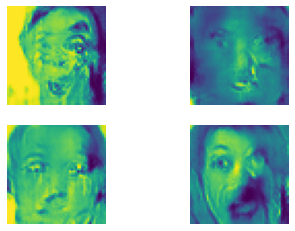

In [57]:
if True:
    # load model
    #model = tf.keras.models.load_model(os.path.join('good_gen_model', f'{val}'_generator_model.h5'))
    model = tf.keras.models.load_model('good_gen_model/' + val + '_generator_model.h5')
    # generate images
    latent_points = generate_latent_points(100, 100)
    # generate images
    X = model.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot the result
    create_plot(X, 2)
    for i in range(10):
        img = array_to_img(X[i])
        img.save(os.path.join('images', f'{val}_generated_img_{i}.png'))